### question 3

In [1]:
pip install simpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import simpy
import random

def customer(env, name, server):
    """顾客到达并接受服务的过程"""
    arrival_time = env.now
    print(f"{name} 在时间 {arrival_time:.2f} 到达.")

    with server.request() as request:
        yield request
        service_time = random.expovariate(service_rate)
        yield env.timeout(service_time)
        print(f"{name} 在时间 {env.now:.2f} 完成服务.")

def setup(env, num_servers, arrival_rate, service_rate):
    """设置仿真环境和初始过程"""
    # 创建服务台
    server = simpy.Resource(env, capacity=num_servers)

    # 创建初始顾客
    i = 0
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        i += 1
        env.process(customer(env, f'顾客{i}', server))

# 参数设置
num_servers = 2  # 服务台数量
arrival_rate = 5  # 平均每单位时间到达一个顾客
service_rate = 8  # 服务率

# 创建并运行仿真环境
env = simpy.Environment()
env.process(setup(env, num_servers, arrival_rate, service_rate))
env.run(until=1)  # 仿真运行时间


顾客1 在时间 0.47 到达.
顾客2 在时间 0.57 到达.
顾客2 在时间 0.60 完成服务.
顾客3 在时间 0.61 到达.
顾客4 在时间 0.73 到达.
顾客5 在时间 0.80 到达.
顾客1 在时间 0.83 完成服务.
顾客4 在时间 0.86 完成服务.
顾客5 在时间 0.87 完成服务.


In [7]:
import simpy
import random

def customer(env, name, server, wait_times):
    """顾客到达并接受服务的过程"""
    arrival_time = env.now
    with server.request() as request:
        yield request
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)  # 记录等待时间
        service_time = random.expovariate(service_rate)
        yield env.timeout(service_time)

def setup(env, num_servers, arrival_rate, service_rate, wait_times):
    """设置仿真环境和初始过程"""
    server = simpy.Resource(env, capacity=num_servers)
    i = 0
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        i += 1
        env.process(customer(env, f'顾客{i}', server, wait_times))

# 参数设置
num_servers = 2
arrival_rate = 5  # 到达率
service_rate = 8  # 服务率
wait_times = []  # 存储等待时间的列表

# 创建并运行仿真环境
env = simpy.Environment()
env.process(setup(env, num_servers, arrival_rate, service_rate, wait_times))
env.run(until=1)  # 运行仿真时间

# 计算平均等待时间
average_wait = sum(wait_times) / len(wait_times) if wait_times else 0
print(f"平均等待时间: {average_wait:.2f} 单位时间")


平均等待时间: 0.07 单位时间


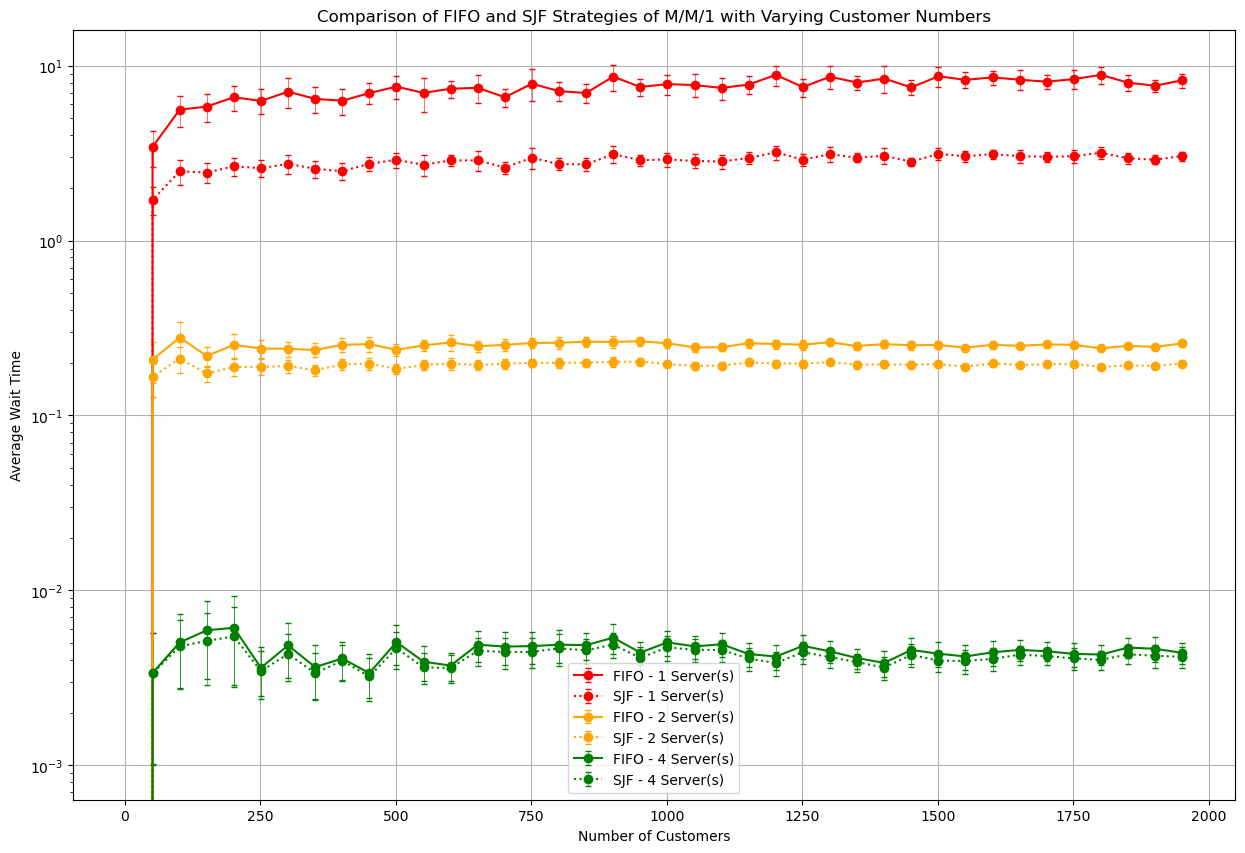

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics

# Assuming λ (arrival rate) and μ (service rate) are defined
λ = 0.9  # Example value
μ = 1.0  # Example value
servers = [1, 2, 4]  # Example server configurations

def generate_customers(num_customers):
    """Generate customers with random arrival and service times."""
    interarrival_times = np.random.exponential(1/λ, num_customers)
    service_times = np.random.exponential(1/μ, num_customers)
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times, service_times

def process_customers_fifo(arrival_times, service_times, num_servers):
    """Process customers in FIFO order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)

    for i in range(num_customers):
        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[i])
        service_ends[next_server] = service_start + service_times[i]
        wait_times[i] = service_start - arrival_times[i]

    return wait_times

def process_customers_sjf(arrival_times, service_times, num_servers):
    """Process customers in SJF order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)
    processed = np.zeros(num_customers, dtype=bool)

    for _ in range(num_customers):
        # Select the next customer: shortest job among those who have arrived
        available = (arrival_times <= np.min(service_ends)) & (~processed)
        if not available.any():
            # If no one has arrived yet, pick the first unprocessed customer
            next_customer = np.where(~processed)[0][0]
        else:
            next_customer = np.where(available)[0][np.argmin(service_times[available])]

        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[next_customer])
        service_ends[next_server] = service_start + service_times[next_customer]
        wait_times[next_customer] = service_start - arrival_times[next_customer]
        processed[next_customer] = True

    return wait_times

# Simulation parameters
customer_numbers = range(1, 2001, 50)  # Range of customer numbers to simulate
num_runs = 50  # Number of simulation runs

average_wait_times_fifo = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}
average_wait_times_sjf = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}

# Simulation
for n in servers:
    for num_customers in customer_numbers:
        fifo_waits_all_runs = []
        sjf_waits_all_runs = []

        for run in range(num_runs):
            random.seed(42 + run)
            arrival_times, service_times = generate_customers(num_customers)

            # FIFO simulation
            fifo_waits = process_customers_fifo(arrival_times, service_times, n)
            fifo_waits_all_runs.append(np.mean(fifo_waits))

            # SJF simulation
            sjf_waits = process_customers_sjf(arrival_times, service_times, n)
            sjf_waits_all_runs.append(np.mean(sjf_waits))

        # Data aggregation
        fifo_avg = statistics.mean(fifo_waits_all_runs)
        fifo_std_dev = statistics.stdev(fifo_waits_all_runs)
        sjf_avg = statistics.mean(sjf_waits_all_runs)
        sjf_std_dev = statistics.stdev(sjf_waits_all_runs)
        fifo_conf_diam = 1.96 * fifo_std_dev / np.sqrt(num_runs)
        sjf_conf_diam = 1.96 * sjf_std_dev / np.sqrt(num_runs)

        average_wait_times_fifo[n]['averages'].append(fifo_avg)
        average_wait_times_fifo[n]['std_devs'].append(fifo_std_dev)
        average_wait_times_fifo[n]['conf_diams'].append(fifo_conf_diam)
        average_wait_times_sjf[n]['averages'].append(sjf_avg)
        average_wait_times_sjf[n]['std_devs'].append(sjf_std_dev)
        average_wait_times_sjf[n]['conf_diams'].append(sjf_conf_diam)

# Plotting
plt.figure(figsize=(15, 10))
color_map = {1: 'red', 2: 'orange', 4: 'green'}

for n in servers:
    plt.errorbar(customer_numbers, average_wait_times_fifo[n]['averages'], 
                 yerr=average_wait_times_fifo[n]['conf_diams'], 
                 label=f'FIFO - {n} Server(s)', 
                 fmt='o-', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)
    plt.errorbar(customer_numbers, average_wait_times_sjf[n]['averages'], 
                 yerr=average_wait_times_sjf[n]['conf_diams'], 
                 label=f'SJF - {n} Server(s)', 
                 fmt='o:', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)

plt.xlabel('Number of Customers')
plt.ylabel('Average Wait Time')
plt.yscale('log')
plt.title('Comparison of FIFO and SJF Strategies of M/M/1 with Varying Customer Numbers')
plt.legend()
plt.grid(True)
plt.show()
